# Lab 07: Hierarchical Clustering 

In [48]:
from os.path import join
import pandas as pd
import numpy as np
import sqlite3
import os
import matplotlib.pyplot as plt
import seaborn as sns

# NEW LIBRARIES
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import linkage, dendrogram

sns.set()

**Please download:**

- `figures/clustering/` folder
- `data/data_preprocessed.csv` file

## Import preprocessed data

In [49]:
df = pd.read_csv(join('..', 'data', 'data_preprocessed.csv'))

In [50]:
df.head()

,age,income,frq,rcn,mnt,clothes,kitchen,small_appliances,toys,house_keeping,...,oh_status_Married,oh_status_Single,oh_status_Together,oh_status_Widow,oh_gender_M,oh_dependents_1.0,oh_description_Kind of OK,oh_description_Meh...,oh_description_OK nice!,oh_description_Take my money!!
0,78,0.743162,1.191605,0.457819,1402,-0.617023,-0.243065,1.216847,0.495837,-0.499274,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
1,88,1.559488,1.100011,-1.535723,1537,0.166160,-0.790228,0.740464,-0.374374,-0.631907,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,34,-1.548542,-0.823463,0.557496,44,-0.834573,1.672006,-0.371096,-0.809480,2.286023,...,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0
3,69,0.845528,0.550447,-1.402820,888,0.383710,0.440889,-0.768082,-0.084304,-0.234007,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
4,69,0.782435,1.008417,-0.871209,1138,0.340200,-0.243065,-0.053508,-0.374374,-0.366640,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0


In [51]:
df.columns

Index(['age', 'income', 'frq', 'rcn', 'mnt', 'clothes', 'kitchen',
       'small_appliances', 'toys', 'house_keeping', 'dependents',
       'per_net_purchase', 'gender', 'education', 'status', 'description',
       'birth_year', 'spent_online', 'oh_education_2nd Cycle',
       'oh_education_Graduation', 'oh_education_Master', 'oh_education_PhD',
       'oh_status_Married', 'oh_status_Single', 'oh_status_Together',
       'oh_status_Widow', 'oh_gender_M', 'oh_dependents_1.0',
       'oh_description_Kind of OK', 'oh_description_Meh...',
       'oh_description_OK nice!', 'oh_description_Take my money!!'],
      dtype='object')

In [52]:
my_path = os.path.join("..", "data", "datamining.db")

# connect to the database
conn = sqlite3.connect(my_path)

# the query
query = """
select age, income, frq, rcn, mnt, clothes, kitchen, small_appliances, toys, house_keeping, dependents, per_net_purchase, g.gender, e.education, m.status, r.description
from customers as c 
    join genders as g on g.id = c.gender_id
    join education_levels as e on e.id = c.education_id
    join marital_status as m on m.id = c.marital_status_id
    join recommendations as r on r.id = c.recommendation_id
order by c.id;
"""

df_original = pd.read_sql_query(query, conn)

In [53]:
print(f"Original data shape: {df_original.shape}")
print(f"Preprocessed data shape: {df.shape}")
print(f"% of rows retained: {df.shape[0] / df_original.shape[0] * 100:.2f}%")

Original data shape: (8998, 16)
Preprocessed data shape: (8817, 32)
% of rows retained: 97.99%


### Checkpoint: What preprocessing did we do to our data ? 

In [54]:
# Splitting feature names into groups
# Remember which metric_features we decided to keep?
metric_features = ['income',
 'frq',
 'rcn',
 'clothes',
 'kitchen',
 'small_appliances',
 'toys',
 'house_keeping',
 'per_net_purchase',
 'spent_online']

non_metric_features = df.columns[df.columns.str.startswith('oh_')].tolist() # 

unused_features = [i for i in df.columns if i not in (metric_features+non_metric_features) ]

### Checkpoint: Remember why we dropped `age`/`birth year` and `mnt` from the metric_features list?


In [55]:
print('metric_features:', metric_features)
print('non_metric_features:', non_metric_features)
print('unused_features:', unused_features)


metric_features: ['income', 'frq', 'rcn', 'clothes', 'kitchen', 'small_appliances', 'toys', 'house_keeping', 'per_net_purchase', 'spent_online']
non_metric_features: ['oh_education_2nd Cycle', 'oh_education_Graduation', 'oh_education_Master', 'oh_education_PhD', 'oh_status_Married', 'oh_status_Single', 'oh_status_Together', 'oh_status_Widow', 'oh_gender_M', 'oh_dependents_1.0', 'oh_description_Kind of OK', 'oh_description_Meh...', 'oh_description_OK nice!', 'oh_description_Take my money!!']
unused_features: ['age', 'mnt', 'dependents', 'gender', 'education', 'status', 'description', 'birth_year']


## **Hierarchical Clustering**

The most common approach is agglomerative (bottom-up):
- Start with each data point as its own cluster (k = N)
- Compute pairwise distances between all clusters
- Merge the two closest clusters
- Update the distance matrix 
- Repeat until all points belong to one cluster (k = 1)

It produces a tree-like structure called a **dendrogram**, showing how data points merge into clusters step-by-step, without pre-specifying the number of clusters.

*Key ideas*: <br>
- Points that merge at small distances are more similar <br>
- Clusters form gradually based on proximity.



<p align="center">
  <img src="../figures/clustering/cluster_points.png" width="400">
</p>


<p align="center">
  <img src="../figures/clustering/hierarch.gif" width="1100">
</p>

(From https://dashee87.github.io/data%20science/general/Clustering-with-Scikit-with-GIFs/)


Can also check: https://claude.ai/public/artifacts/a12a6e5c-f34d-4a4e-a81b-a5ddc8df8917


### Checkpoint: How does it relate to the distance matrix we discussed at the beginning of the course?

### The distance matrix
<p align="center">
  <img src="../figures/clustering/hc_distance_matrix.png">
</p>

### Different types of linkage
<p align="center">
  <img src="https://scikit-learn.org/stable/_images/sphx_glr_plot_linkage_comparison_001.png" width=55%">
</p>

### How are they computed?

<p align="center">
  <img src="../figures/clustering/linkage_types.jpeg" width="30%">
</p>

**Ward linkage**: **minimizes** the sum of squared differences within all clusters ($SS_{w}$) / minimizes the total within-cluster variance <br>It is a variance-minimizing approach and in this sense is similar to the k-means objective function but tackled with an agglomerative hierarchical approach.


### Checkpoint: Classify Hierarchical Clustering along the following axes:

- **Bottom-up** vs **Top-down** <br>
*(Bottom-up: starts with each point as a cluster; Top-down: starts with all points in one cluster)*

- **Greedy/Local** vs **Global/Optimal** <br>
*(Greedy/Local: chooses the best step now and never revisits decisions; Global/Optimal: searches for the best overall solution and can revise decisions)*

- **Deterministic** vs **Stochastic** <br>
*(Deterministic: always produces the same result; Stochastic: involves randomness and may vary between runs)*


### Characteristics:
- *bottom up approach*: each observation starts in its own cluster, and clusters are successively merged together
- *greedy/local algorithm*: at each iteration tries to minimize the distance of cluster merging
- *no realocation*: after an observation is assigned to a cluster, it can no longer change
- *deterministic*: you always get the same answer when you run it
- *scalability*: can become *very slow* for a large number of observations

### Checkpoint: Which types of variables (datatypes) should be used for clustering?

### Exercise 1: Apply the Hierarchical Clustering with ward linkage and with euclidean distance with 5 clusters

In [56]:
# Performing HC
hclust = AgglomerativeClustering(linkage='ward', metric='euclidean', n_clusters=5)
hc_labels = hclust.fit_predict(df[metric_features])
hc_labels

array([0, 0, 1, ..., 1, 2, 2])

### Checkpoint: What do you think its the shape of the `hc_labels`? 

In [57]:
hc_labels.shape

(8817,)

In [58]:
# Characterizing the clusters

labels_series = pd.Series(hc_labels, 
                          name='labels', 
                          index=df.index # WHY df.index ??
                          ) 

df_concat = pd.concat(
    [df, labels_series],
    axis=1)

df_concat

,age,income,frq,rcn,mnt,clothes,kitchen,small_appliances,toys,house_keeping,...,oh_status_Single,oh_status_Together,oh_status_Widow,oh_gender_M,oh_dependents_1.0,oh_description_Kind of OK,oh_description_Meh...,oh_description_OK nice!,oh_description_Take my money!!,labels
0,78,0.743162,1.191605,0.457819,1402,-0.617023,-0.243065,1.216847,0.495837,-0.499274,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0
1,88,1.559488,1.100011,-1.535723,1537,0.166160,-0.790228,0.740464,-0.374374,-0.631907,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0
2,34,-1.548542,-0.823463,0.557496,44,-0.834573,1.672006,-0.371096,-0.809480,2.286023,...,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1
3,69,0.845528,0.550447,-1.402820,888,0.383710,0.440889,-0.768082,-0.084304,-0.234007,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2
4,69,0.782435,1.008417,-0.871209,1138,0.340200,-0.243065,-0.053508,-0.374374,-0.366640,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8812,70,0.618993,0.458853,-1.701851,837,0.209670,0.167308,-0.132905,0.205767,-0.764540,...,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,2
8813,64,0.874744,0.733635,-1.701851,896,0.731791,-0.243065,-0.609288,-0.519409,-0.366640,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,2
8814,49,-0.455617,-0.731869,-1.535723,61,0.079139,-0.106274,-0.053508,0.060732,-0.101374,...,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1
8815,38,-0.596155,0.825229,0.657173,1011,-0.442982,0.577680,0.581670,-0.809480,0.561792,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,2


In [59]:
df_concat[metric_features+['labels']].groupby('labels').mean()

,income,frq,rcn,clothes,kitchen,small_appliances,toys,house_keeping,per_net_purchase,spent_online
labels,,,,,,,,,,
0,1.127360,1.054164,-0.086791,-0.565696,0.231780,0.639929,0.310619,0.148892,-1.352162,0.235598
1,-0.816389,-0.843022,0.084738,-0.190329,-0.130035,0.479371,-0.044491,-0.051491,0.645503,-0.753319
2,0.583921,0.696600,0.028464,0.512591,-0.310472,-0.414163,-0.309056,-0.288473,-0.184634,1.123735
3,-1.286292,-0.877714,0.170377,-1.464165,1.742958,-0.037862,1.366213,1.588910,0.813227,-0.816724
4,-0.141469,-0.441731,-0.195457,1.235357,-0.700710,-1.054846,-0.723419,-0.668869,0.418864,-0.230577


### Are we done?

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

### ... Not yet!

## Defining the linkage method to choose:

**We need to understand the following:**

---
Total variance of the dataset:
$$SS_{t} = \sum_{i=1}^n (x_i - \overline{x})^2$$


Total variance within clusters:
$$SS_{w} = \sum_{k=1}^K \sum_{i=1}^{n_k} (x_i - \overline{x}_k)^2$$

Total variance between clusters:
$$SS_{b} = \sum_{k=1}^K n_k(\overline{x}_k - \overline{x})^2$$


where 

- $n$ is the total number of observations, 
- $x_i$ is the vector of the $i^{th}$ observation, 
- $\overline x$ is the centroid of the data, 
- $K$  is the number of clusters, 
- $n_k$ is the number of observations in the $k^{th}$ cluster,
-  $\overline x_k$ is the centroid of the $k^{th}$ cluster.

---

$$SS_{t} = SS_{w} + SS_{b}$$

--- 

<p align="center">
  <img src="../figures/clustering/ss_figure.png" width="70%">
</p>

Calculate the $SS_t$ values using NumPy:

*Hint: Using numpy*

$x_i$ : `X = data.values`

$\overline{x}$ : `X.mean()`

$\overline{x}_k$ : `X[hc_labels==k].mean()`

$n_k$ : `X[hc_labels==k].shape[0]`



In [60]:
# NUMPY solution:

# x_i       : X = df.values     : data
# x_bar     : X.mean(axis=0)    : centroid of data
# x_k       : X[hc_labels==k]   : points of cluster k
# x_bar_k   : X_k.mean(axis=0)  : centroid of cluster k
# n_k       : X_k.shape[0]

X = df[metric_features].values

# Computing SST
sst_per_feature = np.sum(np.square(X - X.mean(axis=0)), axis=0)
sst = np.sum(sst_per_feature, axis=0)
print(f"SSt: {sst}")

# Computing SSW
ssw_iter = []                   # Outer summation
for i in np.unique(hc_labels):  # Loop for inner summation
    X_k = X[hc_labels == i]     # Data points belonging to cluster k
    inner_sum = np.sum(np.square(X_k - X_k.mean(axis=0)), axis=0)
    ssw_iter.append(inner_sum)  
ssw_per_feature = np.sum(ssw_iter, axis=0)  # Outer summation
ssw = np.sum(ssw_per_feature, axis=0)
print(f"SSw: {ssw}")

# Computing SSB
ssb_iter = []
for i in np.unique(hc_labels):  # Loop for summation
    X_k = X[hc_labels == i]     # Data points belonging to cluster k
    ssb_iter.append(X_k.shape[0] * np.square(X_k.mean(axis=0) - X.mean(axis=0)))

ssb_per_feature = np.sum(ssb_iter, axis=0)
ssb = np.sum(ssb_per_feature, axis=0)
print(f"SSb: {ssb}")

# Verifying the formula
np.round(sst) == np.round((ssw + ssb))

SSt: 88170.0
SSw: 47634.2840179726
SSb: 40535.71598202725


np.True_

### Exercise 2: Calculate the $SS$ values using Pandas:

*Hint:*

$x_i$ : `data`

$\overline{x}$ : `data.mean()`

$\overline{x}_k$ : `data.loc[data['labels']==k].mean()`

$n_k$ : `data.loc[data['labels']==k].shape[0]`



In [91]:
# SSt
df_subset = df[metric_features]

# mean-center
centered = df_subset - df_subset.mean(axis=0)

# per-feature SST
sst_per_feature = np.sum(centered**2, axis=0)

# total SST
sst_pandas = np.sum(sst_per_feature)
print(f"SSt: {sst_pandas}")
print(f"SSt numpy == SSt pandas? {np.round(sst_pandas) == np.round(sst)}")

SSt: 88170.0
SSt numpy == SSt pandas? True


In [62]:
# SSw
ssw_iter = []
for i in np.unique(hc_labels):  # Loop for inner summation
    df_k = df_subset[hc_labels == i]     # Data points belonging to cluster k
    inner_sum = np.sum(np.square(df_k - df_k.mean(axis=0)), axis=0)
    ssw_iter.append(inner_sum)  
ssw_per_feature = np.sum(ssw_iter, axis=0)
ssw_pandas = np.sum(ssw_per_feature, axis=0)

print(f"SSw: {ssw_pandas}")
print(f"SSw numpy == SSw pandas? {np.round(ssw) == np.round(ssw_pandas)}")

SSw: 47634.28401797258
SSw numpy == SSw pandas? True


In [63]:
# SSb
SS_b_pandas = sst_pandas - ssw_pandas
print(f"SSb: {SS_b_pandas}")

print(f"SSb numpy == SSb pandas? {np.round(ssb) == np.round(SS_b_pandas)}")

SSb: 40535.71598202742
SSb numpy == SSb pandas? True


#### Let's wrap them into functions

Please note that for $SS_t$, there's also: 

$$
SST_{\text{total}} = \sum_{j=1}^{p} (n-1)\cdot \text{Var}(feature_j)
$$

In [64]:
# Let's wrap them into functions

def get_ss(df, feats):
    """
    Calculate the sum of squares (SS) for the given DataFrame.

    The sum of squares is computed as the sum of the variances of each column
    multiplied by the number of non-NA/null observations minus one.

    Parameters:
    df (pandas.DataFrame): The input DataFrame for which the sum of squares is to be calculated.
    feats (list of str): A list of feature column names to be used in the calculation.

    Returns:
    float: The sum of squares of the DataFrame.
    """
    df_ = df[feats]
    ss = np.sum(df_.var() * (df_.count() - 1))
    
    return ss 


def get_ssb(df, feats, label_col):
    """
    Calculate the between-group sum of squares (SSB) for the given DataFrame.
    The between-group sum of squares is computed as the sum of the squared differences
    between the mean of each group and the overall mean, weighted by the number of observations
    in each group.

    Parameters:
    df (pandas.DataFrame): The input DataFrame containing the data.
    feats (list of str): A list of feature column names to be used in the calculation.
    label_col (str): The name of the column in the DataFrame that contains the group labels.
    
    Returns
    float: The between-group sum of squares of the DataFrame.
    """
    
    ssb_i = 0
    for i in np.unique(df[label_col]):
        df_ = df.loc[:, feats]
        X_ = df_.values
        X_k = df_.loc[df[label_col] == i].values
        
        ssb_i += (X_k.shape[0] * (np.square(X_k.mean(axis=0) - X_.mean(axis=0))) )

    ssb = np.sum(ssb_i)
    

    return ssb


def get_ssw(df, feats, label_col):
    """
    Calculate the sum of squared within-cluster distances (SSW) for a given DataFrame.

    Parameters:
    df (pandas.DataFrame): The input DataFrame containing the data.
    feats (list of str): A list of feature column names to be used in the calculation.
    label_col (str): The name of the column containing cluster labels.

    Returns:
    float: The sum of squared within-cluster distances (SSW).
    """
    feats_label = feats+[label_col]

    df_k = df[feats_label].groupby(by=label_col).apply(
        lambda col: get_ss(col, feats), 
        include_groups=False
        )

    return df_k.sum()



In [65]:
df_sst_ = get_ss(df_concat, metric_features)
df_ssb_ = get_ssb(df_concat, metric_features, 'labels')
df_ssw_ = get_ssw(df_concat, metric_features, 'labels')

print("SSb:  ", df_ssb_)
print("SSw:  ", df_ssw_)
print("SSt:  ", df_sst_)
print("SSt == SSb+SSw ? ", (df_sst_ == df_ssb_ + df_ssw_))



SSb:   40535.715982027425
SSw:   47634.28401797258
SSt:   88170.0
SSt == SSb+SSw ?  True


## $R^2$

The $R2$ measures how well a clustering structure explains the variation in the data. <br>
It represents the proportion of total variance explained by the **separation** between clusters — higher values indicate **more distinct** and internally cohesive clusters.

It is useful to compare and assess:
- Different linkage methods
- Different numbers of clusters
- Overall clustering structure quality

It is based on: 

$$
SS_t = SS_w + SS_b
$$

$$
SS_b = SS_t - SS_w
$$

---

$$
R^2 = \cfrac{SS_b}{SS_t}
$$

(or) 

$$
R^2 = \cfrac{SS_t - SS_w}{SS_t}
$$

<p align="center">
  <img src="../figures/clustering/ss_k1_kn.png" width="1000">
</p>

<p align="center">
  <img src="../figures/clustering/r2_k1_kn.png" width="1000">
</p>

### Checkpoint: In this previous example what would be the appropriate number of clusters? 

### Let's find the best linkage method

In [66]:
def get_rsq(df, feats, label_col):
    """
    Calculate the R-squared value for a given DataFrame and features.

    Parameters:
    df (pd.DataFrame): The input DataFrame containing the data.
    feats (list): A list of feature column names to be used in the calculation.
    label_col (str): The name of the column containing the labels or cluster assignments.

    Returns:
    float: The R-squared value, representing the proportion of variance explained by the clustering.
    """

    df_sst_ = get_ss(df, feats)                 # get total sum of squares
    df_ssw_ = get_ssw(df, feats, label_col)     # get ss within
    df_ssb_ = df_sst_ - df_ssw_                 # get ss between

    # r2 = ssb/sst 
    return (df_ssb_/df_sst_)
    

### Exercise 3: Complete the following function to compute the $R^2$ for a set of different cluster solutions with a given linkage method

In [67]:
####################################
#### Complete the code in the function
####################################

def get_r2_hc(df, link_method, max_nclus, min_nclus=1, dist="euclidean"):
    """This function computes the R2 for a set of cluster solutions given by the application of a hierarchical method.
    The R2 is a measure of the homogenity of a cluster solution. It is based on SSt = SSw + SSb and R2 = SSb/SSt. 
    
    Parameters:
    df (DataFrame): Dataset to apply clustering
    link_method (str): either "ward", "complete", "average", "single"
    max_nclus (int): maximum number of clusters to compare the methods
    min_nclus (int): minimum number of clusters to compare the methods. Defaults to 1.
    dist (str): distance to use to compute the clustering solution. Must be a valid distance. Defaults to "euclidean".
    
    Returns:
    ndarray: R2 values for the range of cluster solutions
    """
    
    r2 = []  # where we will store the R2 metrics for each cluster solution
    feats = df.columns.tolist()
    
    for i in range(min_nclus, max_nclus+1):  # iterate over desired ncluster range
        
        # CODE HERE ####################################
        cluster = AgglomerativeClustering(linkage=link_method, metric=dist, n_clusters=i)
        
        #get cluster labels
        # CODE HERE ####################################
        hclabels = cluster.fit_predict(df[feats])
        
        # concat df with labels
        df_concat = pd.concat([df, pd.Series(hclabels, name='labels', index=df.index)], axis=1)  
        
        
        # append the R2 of the given cluster solution
        r2.append(get_rsq(df_concat, feats, 'labels'))
        
    return np.array(r2)


### Checkpoint: What will be the shape of the `r2` np.array?

In [68]:
##########################################
# THIS TAKES A FEW MINUTES TO RUN!!
##########################################

hc_methods = ["ward", "complete", "average", "single"]
max_nclus = 10

results = []
for link in hc_methods:
    r2 = get_r2_hc(
        df=df[metric_features], 
        link_method=link, 
        max_nclus=max_nclus, 
        min_nclus=1, 
        dist="euclidean")
    results.append(r2)

r2_hc = np.vstack(results)

In [69]:
r2_hc.shape

(4, 10)

In [70]:
r2_hc_methods = pd.DataFrame(r2_hc.T, index=range(1, max_nclus + 1), columns=hc_methods)

r2_hc_methods


,ward,complete,average,single
1,0.000000,0.000000,0.000000,0.000000
2,0.215818,0.020636,0.000826,0.000826
3,0.330831,0.218476,0.006597,0.001187
4,0.407440,0.262999,0.194732,0.001678
5,0.459745,0.375749,0.209651,0.002119
6,0.485751,0.409316,0.214343,0.002464
7,0.509954,0.413294,0.217500,0.002798
8,0.533628,0.424630,0.218034,0.003091
9,0.548259,0.442085,0.218750,0.003383
10,0.562671,0.496756,0.243123,0.003814


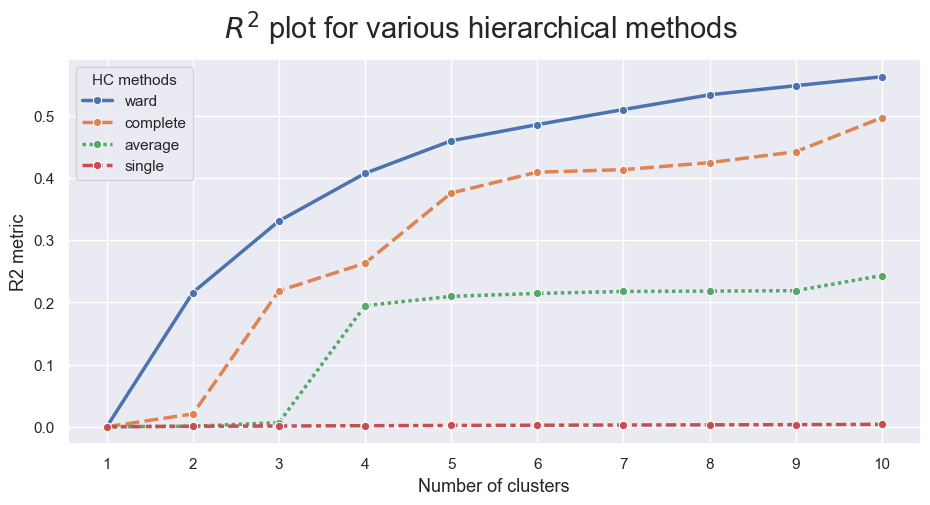

In [71]:
sns.set()

# Plot data
fig = plt.figure(figsize=(11,5))
sns.lineplot(data=r2_hc_methods, linewidth=2.5, markers=["o"]*4)

# Finalize the plot
plt.legend(title="HC methods", title_fontsize=11)
plt.xticks(range(1, max_nclus + 1))
plt.xlabel("Number of clusters", fontsize=13)
plt.ylabel("R2 metric", fontsize=13)

fig.suptitle("$R^2$ plot for various hierarchical methods", fontsize=21)

plt.show()

### Checkpoint: 
- What linkage method do you think is more appropriate? 
- Do you still remenber what parameter the ward method optimizes? 

## Dendrogram

### Checkpoint: Why is the dendrogram useful? 

### Exercise 4: Get the linkage matrix

In [88]:
# setting distance_threshold=0 and n_clusters=None ensures we compute the full tree
linkage = 'ward' # CODE HERE
distance = 'euclidean' # CODE HERE
n_clusters = None # CODE HERE

hclust = AgglomerativeClustering(linkage=linkage, metric=distance, n_clusters=n_clusters, distance_threshold=0)
hclust.fit_predict(df[metric_features])

array([6069, 7663, 7833, ...,    4,    1,    0])

In [89]:
# Adapted from:
# https://scikit-learn.org/stable/auto_examples/cluster/plot_agglomerative_dendrogram.html#sphx-glr-auto-examples-cluster-plot-agglomerative-dendrogram-py

# create the counts of samples under each node (number of points being merged)
counts = np.zeros(hclust.children_.shape[0])
n_samples = len(hclust.labels_)

# hclust.children_ contains the observation ids that are being merged together
# At the i-th iteration, children[i][0] and children[i][1] are merged to form node n_samples + i
for i, merge in enumerate(hclust.children_):
    # track the number of observations in the current cluster being formed
    current_count = 0
    for child_idx in merge:
        if child_idx < n_samples:
            # If this is True, then we are merging an observation
            current_count += 1  # leaf node
        else:
            # Otherwise, we are merging a previously formed cluster
            current_count += counts[child_idx - n_samples]
    counts[i] = current_count

# the hclust.children_ is used to indicate the two points/clusters being merged (dendrogram's u-joins)
# the hclust.distances_ indicates the distance between the two points/clusters (height of the u-joins)
# the counts indicate the number of points being merged (dendrogram's x-axis)
linkage_matrix = np.column_stack(
    [hclust.children_, hclust.distances_, counts]
).astype(float)



Or:

In [74]:
from scipy.cluster.hierarchy import linkage

linkage_matrix= linkage(df[metric_features], method="ward")  # or 'single', 'complete', 'average'

In [75]:
linkage_matrix.shape

# Column	Meaning
# 0	        Index of first cluster merged
# 1	        Index of second cluster merged
# 2	        Distance between them at merge (height in dendrogram)
# 3	        Number of original observations contained in the new cluster

(8816, 4)

### Exercise 5: Visualize the Dendrogram and define an appropriate `y_threshold` 

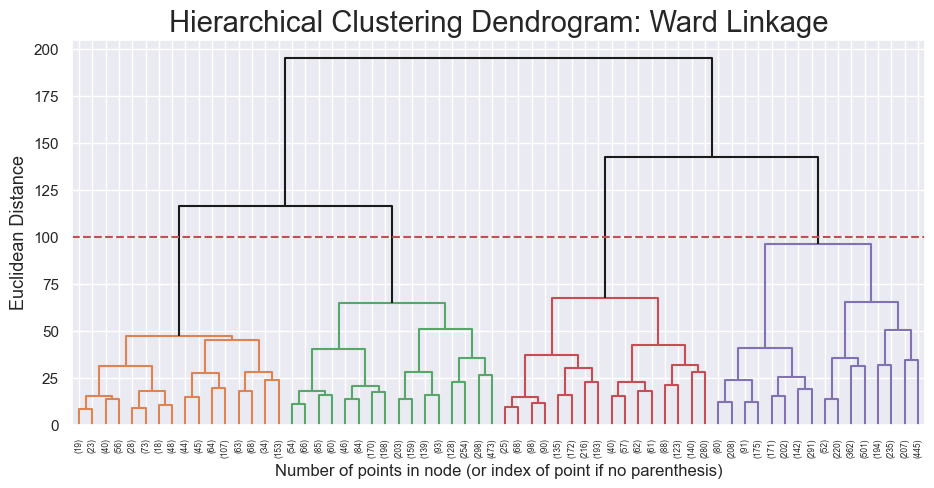

In [93]:
# Plot the corresponding dendrogram
sns.set()
fig = plt.figure(figsize=(11,5))
# The Dendrogram parameters need to be tuned
Y_THRESHOLD = 100 # CODE HERE
dendrogram(linkage_matrix, truncate_mode='level', p=5, color_threshold=Y_THRESHOLD, above_threshold_color='k')
    # You can play with 'truncate_mode' and 'p' define what level the dendrogram shows
    # above_threshold_color='k' forces black color for the lines above the threshold)
plt.hlines(Y_THRESHOLD, 0, 1000, colors="r", linestyles="dashed")
plt.title(f'Hierarchical Clustering Dendrogram: Ward Linkage', fontsize=21)
plt.xlabel('Number of points in node (or index of point if no parenthesis)')
plt.ylabel(f'{distance.title()} Distance', fontsize=13)
plt.show()

### Checkpoint: Where is the first *big jump* in the dendrogam?

### Exercise 6: Complete the code to test with 4 and 5 clusters

In [77]:
linkage = 'ward'
distance = 'euclidean'

In [78]:
# 4 cluster solution
n_clusters = 4

hc4_clust = AgglomerativeClustering(n_clusters=n_clusters)
hc4_labels = hc4_clust.fit_predict(df[metric_features])

In [79]:
# Characterizing the 4 clusters
df_concat = pd.concat([df[metric_features], 
                       pd.Series(hc4_labels, 
                                 name='labels', 
                                 index=df.index)], 
                    axis=1)

df_concat.groupby('labels').mean()

,income,frq,rcn,clothes,kitchen,small_appliances,toys,house_keeping,per_net_purchase,spent_online
labels,,,,,,,,,,
0,0.308045,0.263678,-0.056696,0.787469,-0.458885,-0.657823,-0.466644,-0.433142,0.044884,0.608672
1,-0.816389,-0.843022,0.084738,-0.190329,-0.130035,0.479371,-0.044491,-0.051491,0.645503,-0.753319
2,1.127360,1.054164,-0.086791,-0.565696,0.231780,0.639929,0.310619,0.148892,-1.352162,0.235598
3,-1.286292,-0.877714,0.170377,-1.464165,1.742958,-0.037862,1.366213,1.588910,0.813227,-0.816724


In [80]:
# 5 cluster solution

hc5_clust = AgglomerativeClustering(n_clusters=5)
hc5_labels = hc5_clust.fit_predict(df[metric_features])

In [81]:
# Characterizing the 5 clusters
df_concat = pd.concat([df[metric_features], 
                       pd.Series(hc5_labels, 
                                 name='labels', 
                                 index=df.index)], 
                    axis=1)

df_concat.groupby('labels').mean()

,income,frq,rcn,clothes,kitchen,small_appliances,toys,house_keeping,per_net_purchase,spent_online
labels,,,,,,,,,,
0,1.127360,1.054164,-0.086791,-0.565696,0.231780,0.639929,0.310619,0.148892,-1.352162,0.235598
1,-0.816389,-0.843022,0.084738,-0.190329,-0.130035,0.479371,-0.044491,-0.051491,0.645503,-0.753319
2,0.583921,0.696600,0.028464,0.512591,-0.310472,-0.414163,-0.309056,-0.288473,-0.184634,1.123735
3,-1.286292,-0.877714,0.170377,-1.464165,1.742958,-0.037862,1.366213,1.588910,0.813227,-0.816724
4,-0.141469,-0.441731,-0.195457,1.235357,-0.700710,-1.054846,-0.723419,-0.668869,0.418864,-0.230577


In [82]:
## See crosstab of 4 vs 5

pd.crosstab(
    pd.Series(hc5_labels, name='hc5_labels', index=df.index),
    pd.Series(hc4_labels, name='hc4_labels', index=df.index),
    )

hc4_labels,0,1,2,3
hc5_labels,,,,
0,0,0,1848,0
1,0,2510,0,0
2,2216,0,0,0
3,0,0,0,883
4,1360,0,0,0


### Checkpoint: What does this comparison between 4 and 5 clusters mean? 

## Final Hierarchical Clustering solution

### Exercise 7: Define a final Hierarchical clustering solution and characterize the final clusters using the clusters mean for each feature

In [83]:
# final cluster solution
linkage = "ward" # CODE HERE
distance = "euclidean" # CODE HERE
n_clusters = 4 # CODE HERE
hclust = AgglomerativeClustering(linkage=linkage, metric=distance, n_clusters=n_clusters)

hc_labels = hclust.fit_predict(df[metric_features])

In [84]:
# Characterizing the final clusters

df_concat = pd.concat([
    df[metric_features], 
    pd.Series(hc_labels, name='labels', index=df.index)
    ], 
    axis=1)
df_concat.groupby('labels').mean().T

labels,0,1,2,3
income,0.308045,-0.816389,1.127360,-1.286292
frq,0.263678,-0.843022,1.054164,-0.877714
rcn,-0.056696,0.084738,-0.086791,0.170377
clothes,0.787469,-0.190329,-0.565696,-1.464165
kitchen,-0.458885,-0.130035,0.231780,1.742958
small_appliances,-0.657823,0.479371,0.639929,-0.037862
toys,-0.466644,-0.044491,0.310619,1.366213
house_keeping,-0.433142,-0.051491,0.148892,1.588910
per_net_purchase,0.044884,0.645503,-1.352162,0.813227
spent_online,0.608672,-0.753319,0.235598,-0.816724


### Which plot is adequate to visualize this matrix? 

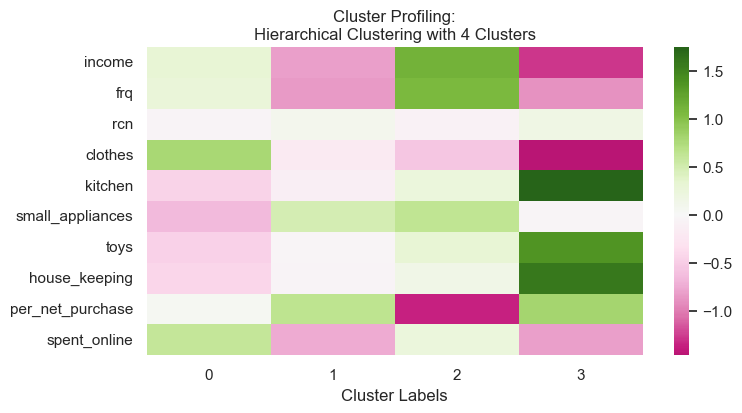

In [85]:
fig, ax = plt.subplots(figsize=(8,4))

hc_profile = df_concat.groupby('labels').mean().T

sns.heatmap(hc_profile,
            ax=ax,
            center=0,
            cmap='PiYG') # How can we improve this?

ax.set_xlabel("Cluster Labels")
ax.set_title("Cluster Profiling:\nHierarchical Clustering with 4 Clusters")
plt.show()

### Checkpoint: How would you characterize each cluster and what marketing strategies you would suggest for each? 

### Exercise 8: Visualize the cluster means with the population means in the same heatmap.



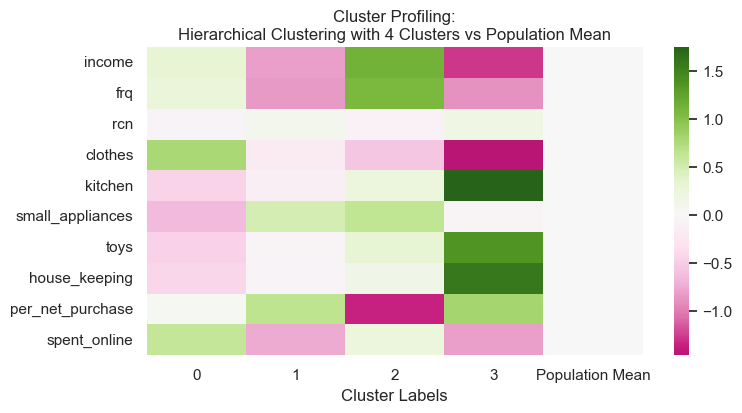

In [86]:
pop_mean = df[metric_features].mean()

df_concat_pop = pd.concat([hc_profile, 
                           pd.Series(pop_mean, 
                                        index=hc_profile.index, 
                                        name='Population Mean'
                            )
                           ],
                           axis=1)

fig, ax = plt.subplots(figsize=(8,4))

sns.heatmap(df_concat_pop,
            ax=ax,
            center=0,
            cmap='PiYG') # How can we improve this?
ax.set_xlabel("Cluster Labels")
ax.set_title("Cluster Profiling:\nHierarchical Clustering with 4 Clusters vs Population Mean")
plt.show()   

### Checkpoint: Why these population mean values? 

### Visualize the cluster means with the cluster sizes

Create a subplot with 1 row and 2 columns.

In the left subplot, visualize the heatmap of cluster means, and in the right subplot visualize the cluster sizes.

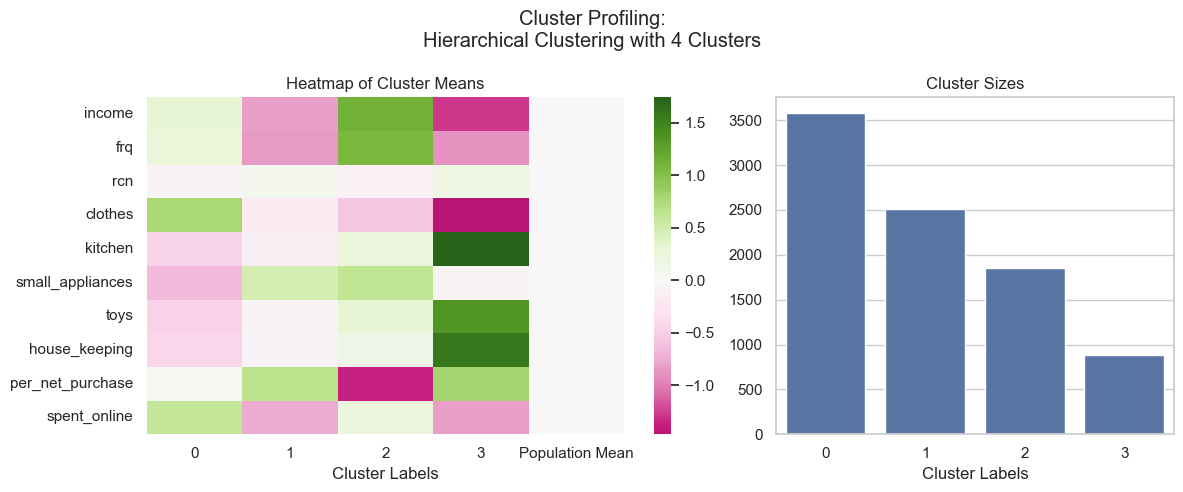

In [87]:
sns.set(style="whitegrid")
label_counts = df_concat['labels'].value_counts().sort_index()

fig, axes = plt.subplots(1,2, figsize=(12,5), width_ratios=[.6,.4], tight_layout=True)

sns.heatmap(df_concat_pop, ax=axes[0], center=0, cmap='PiYG')

axes[0].set_xlabel("Cluster Labels")
axes[0].set_title("Heatmap of Cluster Means")


sns.barplot(x=label_counts.index, y=label_counts.values, ax=axes[1])
axes[1].set_title("Cluster Sizes")
axes[1].set_xlabel("Cluster Labels")

fig.suptitle("Cluster Profiling:\nHierarchical Clustering with 4 Clusters")
plt.show()

### Checkpoint: Why it might be important to access the cluster sizes? What could the the most valuable cluster?

### Checkpoint: Identify the letter in the dendrogram corresponding to each point in the scatter plot

The figure below shows the dendrogram produced by using the **single** linkage method to cluster the datapoints given. <br>Identify the letter in the dendrogram corresponding to each point in the scatter plot:

*Example:* Point 10 = Letter L

![HC Exercise](./../figures/clustering/hc_exer_01.png)

### More references on cluster evaluation:


Halkidi, M., Batistakis, Y., & Vazirgiannis, M. (2002). Clustering validity checking methods. *ACM SIGMOD Record*, 31(3), 19–27. https://doi.org/10.1145/601858.601862

Liu, Y., Li, Z., Xiong, H., Gao, X. & Wu, J. (2010), Understanding of Internal Clustering Validation Measures, *2010 IEEE International Conference on Data Mining*, Sydney, NSW, Australia, 2010, pp. 911-916, https://10.1109/ICDM.2010.35. 


Pandove, D., Goel, S., & Rani, R. (2018). Systematic Review of Clustering High-Dimensional and Large Datasets. *ACM Transactions on Knowledge Discovery From Data*, 12(2), 1–68. https://doi.org/10.1145/3132088


Todeschini, R., Ballabio, D., Termopoli, V., & Consonni, V. (2024). Extended multivariate comparison of 68 cluster validity indices. A review. *Chemometrics and Intelligent Laboratory Systems*, 251, 105117. https://doi.org/10.1016/j.chemolab.2024.105117



## Questions?

## Next Session: K-Means Clustering